###  Encoding Strategy Comparison (Experimental)

In this section, we tried:
- LabelEncoder from sklearn (basic ordinal encoding)
- Manual ordinal label mappings based on domain knowledge
- Compared against baseline One-Hot Encoding

The code is commented out for clarity, but results are summarized below:
- Logistic Regression AUC: 0.712,0.7121 and 0.7589 for LabelEncoder, Manual ordinal mappings and One-Hot Encoding respectively
- Random Forest AUC: 0.749, 0.7679 and 0.7820 for LabelEncoder, Manual ordinal mappings and One-Hot Encoding respectively

### Final Decision: Stick with One-Hot Encoding due to higher ROC-AUC and better class balance handling.


In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

In [2]:
#load the credit dataset from OpenML
data = fetch_openml(name="credit-g",version=1, as_frame= True)

In [3]:
#Convert to DataFrame
df=data.frame
#Preview
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


In [4]:
#Check dataset shape and column info
print(f"Dataset shape : {df.shape}")
df.info()

Dataset shape : (1000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   int64   
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   int64   
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   int64   
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   int64   
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   int64   
 13  other_payment_plans     1000 non-null   category
 14

In [5]:
#Check for missing values
df.isnull().sum().sort_values(ascending=False)

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
dtype: int64

In [6]:
for col in df.columns:
    uniques = df[col].unique()
    if "?" in uniques or "Unknown" in uniques:
        print(f"Missing flag detected in : {col}")
else:
    print("all ok")

all ok


In [7]:
#Target variable is "class"
df['class'].value_counts(normalize=True)

class
good    0.7
bad     0.3
Name: proportion, dtype: float64

In [8]:
df.dtypes.value_counts()

int64       7
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
Name: count, dtype: int64

In [9]:
df.select_dtypes(include='category').shape[1]

14

In [10]:
cat_cols = df.select_dtypes(include='category').columns.tolist()
print(f"Categorical Columns ({len(cat_cols)}): \n {cat_cols}")

Categorical Columns (14): 
 ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker', 'class']


In [11]:
df['housing'].dtype

CategoricalDtype(categories=['for free', 'own', 'rent'], ordered=False, categories_dtype=object)

In [12]:
#drop target temporarily
x = df.drop('class', axis=1)

In [13]:
# Label encode all ordinal categorical features
"""from sklearn.preprocessing import LabelEncoder
l_e= LabelEncoder()
ordinal_columns =['checking_status', 'credit_history','savings_status', 'employment']
for col in ordinal_columns:
    x[col] =l_e.fit_transform(x[col])
    
x.head()"""

"from sklearn.preprocessing import LabelEncoder\nl_e= LabelEncoder()\nordinal_columns =['checking_status', 'credit_history','savings_status', 'employment']\nfor col in ordinal_columns:\n    x[col] =l_e.fit_transform(x[col])\n    \nx.head()"

In [14]:
# manual encoding/mapping of ordinal categorical features

# Custom ordinal encodings based on domain knowledge
checking_status_map = {
    'no checking': 0,
    '<0': 1,
    '0<=X<200': 2,
    '>=200': 3
}

savings_status_map = {
    'no known savings': 0,
    '<100': 1,
    '100<=X<500': 2,
    '500<=X<1000': 3,
    '>=1000': 4
}

employment_map = {
    'unemployed': 0,
    '<1': 1,
    '1<=X<4': 2,
    '4<=X<7': 3,
    '>=7': 4
}

credit_history_map = {
    'critical/other existing credit': 0,
    'delayed previously': 1,
    'existing paid': 2,
    'all paid': 3,
    'no credits/all paid': 4
}

# Apply maps
x['checking_status'] = x['checking_status'].map(checking_status_map)
x['savings_status'] = x['savings_status'].map(savings_status_map)
x['employment'] = x['employment'].map(employment_map)
x['credit_history'] = x['credit_history'].map(credit_history_map)

x.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,1,6,0,radio/tv,1169,0,4,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,2,48,2,radio/tv,5951,1,2,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,0,12,0,education,2096,1,3,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes
3,1,42,2,furniture/equipment,7882,1,3,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes
4,1,24,1,new car,4870,1,2,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes


In [45]:
from sklearn.preprocessing import LabelEncoder
l_e= LabelEncoder()
ordinal_columns =['checking_status', 'credit_history','savings_status', 'employment']
for col in ordinal_columns:
    x[col] =l_e.fit_transform(x[col])
    
x.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,1,6,0,radio/tv,1169,0,4,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,2,48,2,radio/tv,5951,1,2,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,0,12,0,education,2096,1,3,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes
3,1,42,2,furniture/equipment,7882,1,3,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes
4,1,24,1,new car,4870,1,2,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes


In [16]:
#one-hot encode rest of the categorical features
'''cat_cols = x.select_dtypes(include=['object', 'category']).columns.tolist()
nominal_cols = [col for col in cat_cols if col not in ['checking_status', 'savings_status', 'employment', 'credit_history']]
nominal_cols
x_encoded = pd.get_dummies(x, columns=nominal_cols, drop_first=True)
x_encoded.head()'''

"cat_cols = x.select_dtypes(include=['object', 'category']).columns.tolist()\nnominal_cols = [col for col in cat_cols if col not in ['checking_status', 'savings_status', 'employment', 'credit_history']]\nnominal_cols\nx_encoded = pd.get_dummies(x, columns=nominal_cols, drop_first=True)\nx_encoded.head()"

In [17]:
#one-hot encode rest of the categorical features
x_encoded = pd.get_dummies(x, drop_first=True)
x_encoded.head()

,checking_status,duration,credit_history,credit_amount,savings_status,employment,installment_commitment,residence_since,age,existing_credits,...,property_magnitude_car,other_payment_plans_none,other_payment_plans_stores,housing_own,housing_rent,job_unemp/unskilled non res,job_unskilled resident,job_skilled,own_telephone_yes,foreign_worker_yes
0,1,6,0,1169,0,4,4,4,67,2,...,False,True,False,True,False,False,False,True,True,True
1,2,48,2,5951,1,2,2,2,22,1,...,False,True,False,True,False,False,False,True,False,True
2,0,12,0,2096,1,3,2,3,49,1,...,False,True,False,True,False,False,True,False,False,True
3,1,42,2,7882,1,3,2,4,45,1,...,False,True,False,False,False,False,False,True,False,True
4,1,24,1,4870,1,2,3,4,53,2,...,False,True,False,False,False,False,False,True,False,True


In [18]:
#add target back (map good/bad to binary)
y = df['class'].map({'good': 1, "bad": 0})
y.head()

0    1
1    0
2    1
3    1
4    0
Name: class, dtype: category
Categories (2, int64): [0, 1]

In [19]:
#confirm shapes
print(f"x_encoded shape: {x_encoded.shape}")
print(f"target value counts :\n{y.value_counts(normalize=True)}")

x_encoded shape: (1000, 37)
target value counts :
class
1    0.7
0    0.3
Name: proportion, dtype: float64


In [20]:
from sklearn.model_selection import train_test_split
#stratified train-test split
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, stratify=y, random_state=42)

#confirm class balance in splits
print("train target class balance:")
print(y_train.value_counts(normalize=True))

print("\ntest target class balance:")
print(y_test.value_counts(normalize=True))

train target class balance:
class
1    0.7
0    0.3
Name: proportion, dtype: float64

test target class balance:
class
1    0.7
0    0.3
Name: proportion, dtype: float64


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,f1_score, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt

In [22]:
'''results={}
solvers=['liblinear','lbfgs','sag','saga','newton-cg']
for s in solvers:
    try:
        model = LogisticRegression(solver=s, max_iter=1000)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)[:,1]
        
        results[s]={ 'accuracy': accuracy_score(y_test, y_pred),'f1':f1_score(y_test, y_pred), 'roc_auc': roc_auc_score(y_test, y_prob)}
        
    except Exception as e:
        print(f"{s} failed:{e}")

df_results= pd.DataFrame(results).T

df_results.plot(kind='bar', figsize=(10,5), colormap='Set2')
plt.title('l2 solver comparison - logistic regression')
plt.ylabel('score')
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show'''

'results={}\nsolvers=[\'liblinear\',\'lbfgs\',\'sag\',\'saga\',\'newton-cg\']\nfor s in solvers:\n    try:\n        model = LogisticRegression(solver=s, max_iter=1000)\n        model.fit(x_train, y_train)\n        y_pred = model.predict(x_test)\n        y_prob = model.predict_proba(x_test)[:,1]\n        \n        results[s]={ \'accuracy\': accuracy_score(y_test, y_pred),\'f1\':f1_score(y_test, y_pred), \'roc_auc\': roc_auc_score(y_test, y_prob)}\n        \n    except Exception as e:\n        print(f"{s} failed:{e}")\n\ndf_results= pd.DataFrame(results).T\n\ndf_results.plot(kind=\'bar\', figsize=(10,5), colormap=\'Set2\')\nplt.title(\'l2 solver comparison - logistic regression\')\nplt.ylabel(\'score\')\nplt.xticks(rotation=0)\nplt.grid(True, axis=\'y\')\nplt.legend(loc=\'lower right\')\nplt.tight_layout()\nplt.show'

In [23]:
""""results_1={}
solvers=['liblinear','lbfgs','sag','saga','newton-cg']
for s in solvers:
    try:
        model = LogisticRegression(penalty='l1',solver=s, max_iter=1000)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)[:,1]
        
        results_1[s]={ 'accuracy': accuracy_score(y_test, y_pred),'f1':f1_score(y_test, y_pred), 'roc_auc': roc_auc_score(y_test, y_prob)}
        
    except Exception as e:
        print(f"{s} failed:{e}")

df_results_1= pd.DataFrame(results_1).T

df_results_1.plot(kind='bar', figsize=(10,5), colormap='Set2')
plt.title('l1 solver comparison - logistic regression')
plt.ylabel('score')
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show"""

'"results_1={}\nsolvers=[\'liblinear\',\'lbfgs\',\'sag\',\'saga\',\'newton-cg\']\nfor s in solvers:\n    try:\n        model = LogisticRegression(penalty=\'l1\',solver=s, max_iter=1000)\n        model.fit(x_train, y_train)\n        y_pred = model.predict(x_test)\n        y_prob = model.predict_proba(x_test)[:,1]\n        \n        results_1[s]={ \'accuracy\': accuracy_score(y_test, y_pred),\'f1\':f1_score(y_test, y_pred), \'roc_auc\': roc_auc_score(y_test, y_prob)}\n        \n    except Exception as e:\n        print(f"{s} failed:{e}")\n\ndf_results_1= pd.DataFrame(results_1).T\n\ndf_results_1.plot(kind=\'bar\', figsize=(10,5), colormap=\'Set2\')\nplt.title(\'l1 solver comparison - logistic regression\')\nplt.ylabel(\'score\')\nplt.xticks(rotation=0)\nplt.grid(True, axis=\'y\')\nplt.legend(loc=\'lower right\')\nplt.tight_layout()\nplt.show'

In [24]:
#initialize model
logreg = LogisticRegression(penalty='l1',solver= 'liblinear',max_iter=2000)

In [25]:
#train
logreg.fit(x_train, y_train)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,2000
,multi_class,'deprecated'


In [26]:
coef=logreg.coef_[0]
num_zero = np.sum(coef == 0)
print(f"l1 penalty set {num_zero} features to zero out of {len(coef)}")

l1 penalty set 6 features to zero out of 37


In [27]:
#predict
y_pred_l1 = logreg.predict(x_test)
y_prob_l1 = logreg.predict_proba(x_test)[:, 1]

In [28]:
#confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_l1))

#classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_l1))

#ROC AUC Score
roc_score_l1 = roc_auc_score(y_test, y_prob_l1)
print(f"ROC AUC Score:{roc_score_l1: .4f}")

Confusion Matrix:
[[ 23  37]
 [ 23 117]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.38      0.43        60
           1       0.76      0.84      0.80       140

    accuracy                           0.70       200
   macro avg       0.63      0.61      0.61       200
weighted avg       0.68      0.70      0.69       200

ROC AUC Score: 0.7121


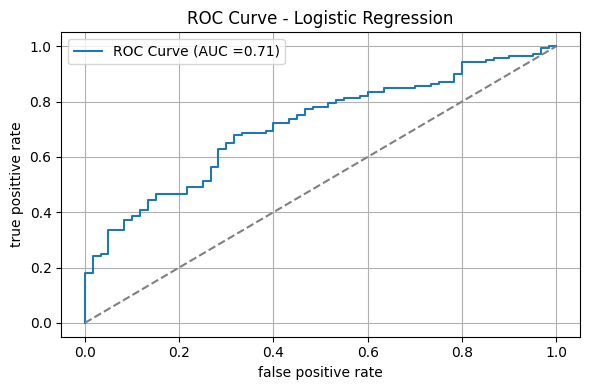

In [29]:
#ROC Curve
fpr,tpr,thresholds = roc_curve(y_test, y_prob_l1)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label = f"ROC Curve (AUC ={roc_score_l1:.2f})")
plt.plot([0,1],[0,1],linestyle='--', color='gray')
plt.xlabel('false positive rate')
plt.ylabel('true posittive rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

In [31]:
#initialize the model
rf_model = RandomForestClassifier(n_estimators=140, max_depth=None, random_state=42, class_weight="balanced")

In [32]:
#train the model
rf_model.fit(x_train, y_train)

,n_estimators,140
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [33]:
y_pred_rf = rf_model.predict(x_test)
y_proba_rf = rf_model.predict_proba(x_test)[:,1] #needed for AUC

In [34]:
#evaluate
print("confusion matrix : \n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report :\n", classification_report(y_test, y_pred_rf))
print("\nROC AUC Score : ", roc_auc_score(y_test, y_proba_rf))

confusion matrix : 
 [[ 22  38]
 [ 15 125]]

Classification Report :
               precision    recall  f1-score   support

           0       0.59      0.37      0.45        60
           1       0.77      0.89      0.83       140

    accuracy                           0.73       200
   macro avg       0.68      0.63      0.64       200
weighted avg       0.72      0.73      0.71       200


ROC AUC Score :  0.7679166666666668


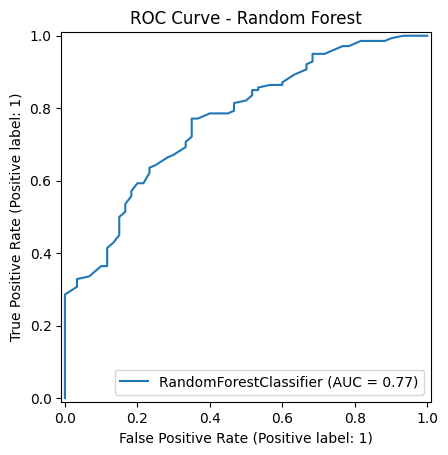

In [35]:
# ROC Curve Plot
RocCurveDisplay.from_estimator(rf_model, x_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

In [36]:
'''scores=[]
for n in range(10,201,10):
    rf_tr=RandomForestClassifier(n_estimators=n, class_weight='balanced',random_state=42)
    rf_tr.fit(x_train, y_train)
    y_proba1= rf_tr.predict_proba(x_test)[:,1]
    auc = roc_auc_score(y_test, y_proba1)
    scores.append((n,auc))
    
x, y =zip(*scores)
plt.plot(x,y)
plt.xlabel("n_estimators")
plt.ylabel("ROC AUC")
plt.title("AUC vs Number of Trees")
plt.grid()
plt.show()'''
                                

'scores=[]\nfor n in range(10,201,10):\n    rf_tr=RandomForestClassifier(n_estimators=n, class_weight=\'balanced\',random_state=42)\n    rf_tr.fit(x_train, y_train)\n    y_proba1= rf_tr.predict_proba(x_test)[:,1]\n    auc = roc_auc_score(y_test, y_proba1)\n    scores.append((n,auc))\n    \nx, y =zip(*scores)\nplt.plot(x,y)\nplt.xlabel("n_estimators")\nplt.ylabel("ROC AUC")\nplt.title("AUC vs Number of Trees")\nplt.grid()\nplt.show()'

In [37]:
import seaborn as sns


In [38]:
#get feature importances from the trained model
importances= rf_model.feature_importances_

In [39]:
#match them to the column names
feature_names=x_encoded.columns
feat_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})


In [40]:
#sort by importance
feat_importance_df= feat_importance_df.sort_values(by='importance',ascending=False).head(15)

C:\Users\VISHNUMAYA R NAIR\AppData\Local\Temp\ipykernel_7828\707101969.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_importance_df, palette=colors)


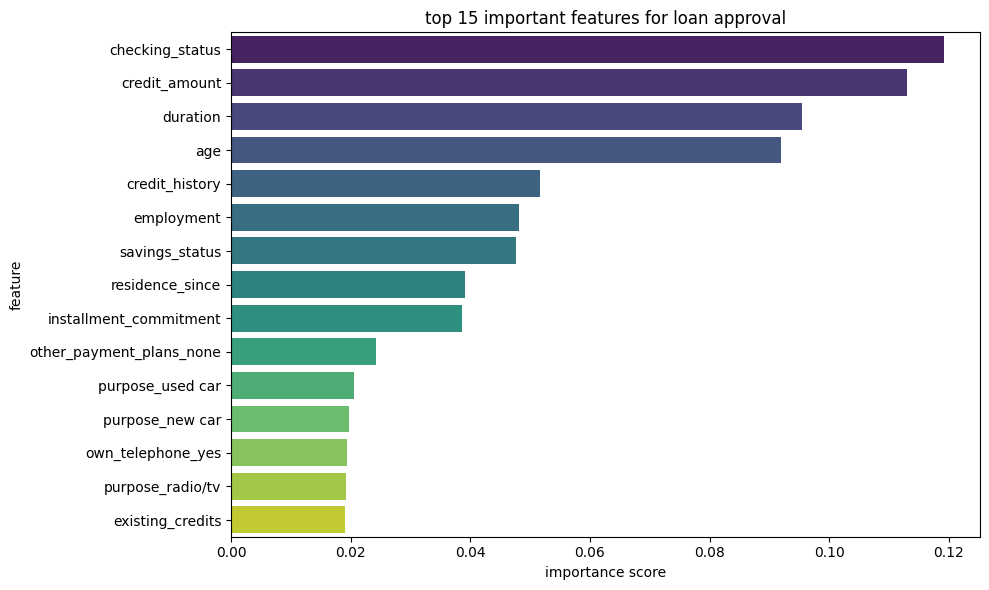

In [41]:
#plot the top 15
colors=sns.color_palette('viridis',len(feat_importance_df))
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_importance_df, palette=colors)
plt.title('top 15 important features for loan approval')
plt.xlabel('importance score')
plt.ylabel('feature')
plt.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [43]:
comparison_df = pd.DataFrame({'metrics': ['ROC AUC', 'accuracy', 'precision', 'recall', 'fi score'], 'Logistic regression (l1)':
                             [roc_auc_score(y_test, y_prob_l1),logreg.score(x_test, y_test), precision_score(y_test, y_pred_l1),
                              recall_score(y_test, y_pred_l1), f1_score(y_test,y_pred_l1)],
                              'Random forest':[roc_auc_score(y_test, y_proba_rf), rf_model.score(x_test,y_test),precision_score(y_test, y_pred_rf),
                              recall_score(y_test, y_pred_rf), f1_score(y_test, y_pred_rf)]})

# round for clean display
print(comparison_df.round(4))
                                                                                                             

     metrics  Logistic regression (l1)  Random forest
0    ROC AUC                    0.7121         0.7679
1   accuracy                    0.7000         0.7350
2  precision                    0.7597         0.7669
3     recall                    0.8357         0.8929
4   fi score                    0.7959         0.8251


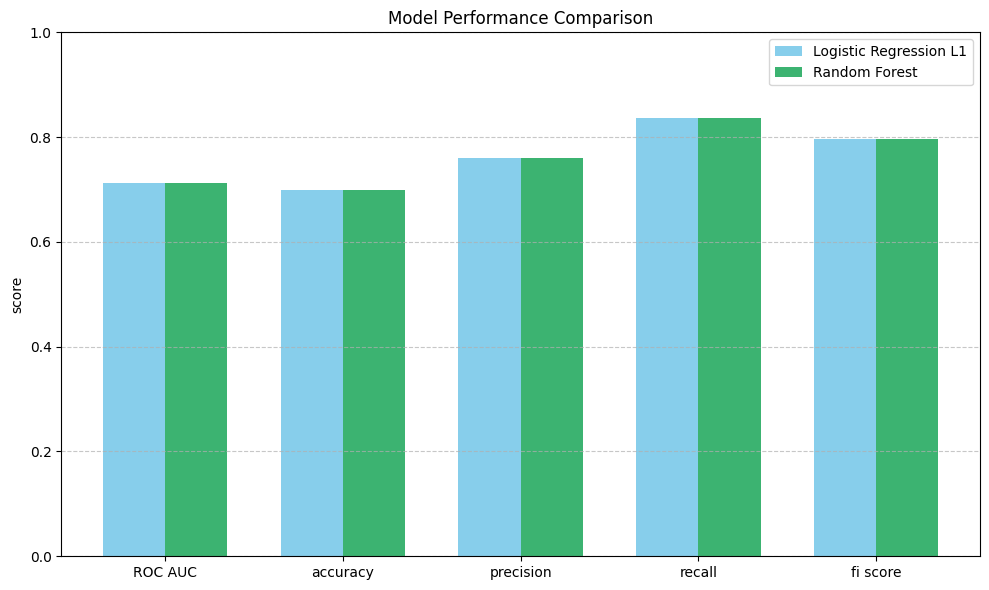

In [44]:
# graphical representation
metrics = ['ROC AUC', 'accuracy', 'precision', 'recall', 'fi score']
lr_scores = [roc_auc_score(y_test, y_prob_l1),logreg.score(x_test, y_test), precision_score(y_test, y_pred_l1),
            recall_score(y_test, y_pred_l1), f1_score(y_test,y_pred_l1)]
rf_scores = [roc_auc_score(y_test, y_proba_rf), rf_model.score(x_test,y_test),precision_score(y_test, y_pred_rf),
            recall_score(y_test, y_pred_rf), f1_score(y_test, y_pred_rf)]

a = np.arange(len(metrics)) # label locations
width = 0.35 # width of the bars

plt.figure(figsize=(10,6))
plt.bar(a-width/2,lr_scores, width, label='Logistic Regression L1', color ='skyblue')
plt.bar(a+width/2,lr_scores, width, label='Random Forest', color ='mediumseagreen')

plt.ylabel('score')
plt.title('Model Performance Comparison')
plt.xticks(ticks=a, labels=metrics)
plt.ylim(0,1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()